The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install d2l==1.0.0-alpha1.post0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 1.2 MB/s 
     |████████████████████████████████| 120 kB 34.8 MB/s 
     |████████████████████████████████| 1.6 MB 57.1 MB/s 
     |████████████████████████████████| 82 kB 948 kB/s 


# Attention Cues
:label:`sec_attention-cues`

Thank you for your attention
to this book.
Attention is a scarce resource:
at the moment
you are reading this book
and ignoring the rest.
Thus, similar to money,
your attention is being paid with an opportunity cost.
To ensure that your investment of attention
right now is worthwhile,
we have been highly motivated to pay our attention carefully
to produce a nice book.
Attention
is the keystone in the arch of life and
holds the key to any work's exceptionalism.


Since economics studies the allocation of scarce resources,
we are
in the era of the attention economy,
where human attention is treated as a limited, valuable, and scarce commodity
that can be exchanged.
Numerous business models have been
developed to capitalize on it.
On music or video streaming services,
we either pay attention to their ads
or pay money to hide them.
For growth in the world of online games,
we either pay attention to
participate in battles, which attract new gamers,
or pay money to instantly become powerful.
Nothing comes for free.

All in all,
information in our environment is not scarce,
attention is.
When inspecting a visual scene,
our optic nerve receives information
at the order of $10^8$ bits per second,
far exceeding what our brain can fully process.
Fortunately,
our ancestors had learned from experience (also known as data)
that *not all sensory inputs are created equal*.
Throughout human history,
the capability of directing attention
to only a fraction of information of interest
has enabled our brain
to allocate resources more smartly
to survive, to grow, and to socialize,
such as detecting predators, preys, and mates.



## Attention Cues in Biology

To explain how our attention is deployed in the visual world,
a two-component framework has emerged
and been pervasive.
This idea dates back to William James in the 1890s,
who is considered the "father of American psychology" :cite:`James.2007`.
In this framework,
subjects selectively direct the spotlight of attention
using both the *nonvolitional cue* and *volitional cue*.

The nonvolitional cue is based on
the saliency and conspicuity of objects in the environment.
Imagine there are five objects in front of you:
a newspaper, a research paper, a cup of coffee, a notebook, and a book such as in :numref:`fig_eye-coffee`.
While all the paper products are printed in black and white,
the coffee cup is red.
In other words,
this coffee is intrinsically salient and conspicuous in
this visual environment,
automatically and involuntarily drawing attention.
So you bring the fovea (the center of the macula where visual acuity is highest) onto the coffee as shown in :numref:`fig_eye-coffee`.

![Using the nonvolitional cue based on saliency (red cup, non-paper), attention is involuntarily directed to the coffee.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/eye-coffee.png?raw=1)
:width:`400px`
:label:`fig_eye-coffee`

After drinking coffee,
you become caffeinated and
want to read a book.
So you turn your head, refocus your eyes,
and look at the book as depicted in :numref:`fig_eye-book`.
Different from
the case in :numref:`fig_eye-coffee`
where the coffee biases you towards
selecting based on saliency,
in this task-dependent case you select the book under
cognitive and volitional control.
Using the volitional cue based on variable selection criteria,
this form of attention is more deliberate.
It is also more powerful with the subject's voluntary effort.

![Using the volitional cue (want to read a book) that is task-dependent, attention is directed to the book under volitional control.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/eye-book.png?raw=1)
:width:`400px`
:label:`fig_eye-book`


## Queries, Keys, and Values

Inspired by the nonvolitional and volitional attention cues that explain the attentional deployment,
in the following we will
describe a framework for
designing attention mechanisms
by incorporating these two attention cues.

To begin with, consider the simpler case where only
nonvolitional cues are available.
To bias selection over sensory inputs,
we can simply use
a parameterized fully connected layer
or even non-parameterized
max or average pooling.

Therefore,
what sets attention mechanisms
apart from those fully connected layers
or pooling layers
is the inclusion of the volitional cues.
In the context of attention mechanisms,
we refer to volitional cues as *queries*.
Given any query,
attention mechanisms
bias selection over sensory inputs (e.g., intermediate feature representations)
via *attention pooling*.
These sensory inputs are called *values* in the context of attention mechanisms.
More generally,
every value is paired with a *key*,
which can be thought of the nonvolitional cue of that sensory input.
As shown in :numref:`fig_qkv`,
we can design attention pooling
so that the given query (volitional cue) can interact with keys (nonvolitional cues),
which guides bias selection over values (sensory inputs).

![Attention mechanisms bias selection over values (sensory inputs) via attention pooling, which incorporates queries (volitional cues) and keys (nonvolitional cues).](http://d2l.ai/_images/qkv.svg)
:label:`fig_qkv`

Note that there are many alternatives for the design of attention mechanisms.
For instance,
we can design a non-differentiable attention model
that can be trained using reinforcement learning methods :cite:`Mnih.Heess.Graves.ea.2014`.
Given the dominance of the framework in :numref:`fig_qkv`,
models under this framework
will be the center of our attention in this chapter.


## Visualization of Attention

Average pooling
can be treated as a weighted average of inputs,
where weights are uniform.
In practice,
attention pooling aggregates values using weighted average, where weights are computed between the given query and different keys.


In [2]:
import torch
from d2l import torch as d2l

To visualize attention weights,
we define the `show_heatmaps` function.
Its input `matrices` has the shape (number of rows for display, number of columns for display, number of queries, number of keys).


In [3]:
#@save
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """Show heatmaps of matrices."""
    d2l.use_svg_display()
    num_rows, num_cols = len(matrices), len(matrices[0])
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

For demonstration,
we consider a simple case where
the attention weight is one only when the query and the key are the same; otherwise it is zero.


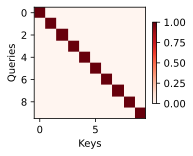

In [4]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

In the subsequent sections,
we will often invoke this function to visualize attention weights.

## Summary

* Human attention is a limited, valuable, and scarce resource.
* Subjects selectively direct attention using both the nonvolitional and volitional cues. The former is based on saliency and the latter is task-dependent.
* Attention mechanisms are different from fully connected layers or pooling layers due to inclusion of the volitional cues.
* Attention mechanisms bias selection over values (sensory inputs) via attention pooling, which incorporates queries (volitional cues) and keys (nonvolitional cues). Keys and values are paired.
* We can visualize attention weights between queries and keys.

## Exercises

1. What can be the volitional cue when decoding a sequence token by token in machine translation? What are the nonvolitional cues and the sensory inputs?
1. Randomly generate a $10 \times 10$ matrix and use the softmax operation to ensure each row is a valid probability distribution. Visualize the output attention weights.


[Discussions](https://discuss.d2l.ai/t/1592)
